### Урок 3. Логистическая регрессия. Log Loss

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2) 

In [42]:
%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

In [43]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64) # квалификация репетитора

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # подходит или нет репетитор

In [44]:
#Если предсказывать с помощью линейной регрессии, то могут появляться такие числа:   

#-1, -0.2, 1.3, 0.05 ...

In [45]:
p = [0, 1]

In [46]:
#$odds = \frac{p}{1 - p} = \frac{p_1}{p_0}$

In [47]:
0.5 / (1 - 0.5)

1.0

In [48]:
0.01 / (1 - 0.01)

0.010101010101010102

In [49]:
0.9999 / (1 - 0.9999)

9999.0000000011

In [50]:
p = 1e-10
np.log(p / (1 - p))                       

-23.025850929840455

In [51]:
p = 0.999
np.log(p / (1 - p))

6.906754778648553

In [52]:
#$$\vec{w}X = \ln\Big(\frac{\vec{p}}{1 - \vec{p}}\Big)$$
#$$\vec{p}=\frac{1}{1+\exp{(-\vec{w}X)}}$$

In [53]:
X

array([[1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00],
       [1.00e+00, 1.00e+00, 2.00e+00, 1.00e+00, 3.00e+00, 0.00e+00,
        5.00e+00, 1.00e+01, 1.00e+00, 2.00e+00],
       [5.00e+02, 7.00e+02, 7.50e+02, 6.00e+02, 1.45e+03, 8.00e+02,
        1.50e+03, 2.00e+03, 4.50e+02, 1.00e+03],
       [1.00e+00, 1.00e+00, 2.00e+00, 1.00e+00, 2.00e+00, 1.00e+00,
        3.00e+00, 3.00e+00, 1.00e+00, 2.00e+00]])

In [54]:
y

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [55]:
def calc_std_feat(x):
    res = (x - x.mean()) / x.std()
    return res

X_st = X.copy()
X_st[2, :] = calc_std_feat(X[2, :])
X_st[2, :]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

$$Logloss=-y \ln(p) - (1-y)\ln(1-p)$$

In [56]:
def calc_logloss(y, y_pred):
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [57]:
# Пример применения
y_true = 1
y_pred = 0.00001
calc_logloss(y_true, y_pred)

11.512925464970229

In [58]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [59]:
z = np.linspace(-10, 10, 101)
z

array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
        -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
        -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,
        -4.6,  -4.4,  -4.2,  -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,
        -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,
        -1. ,  -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,
         0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,
         2.6,   2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,
         4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,
         6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,
         8. ,   8.2,   8.4,   8.6,   8.8,   9. ,   9.2,   9.4,   9.6,
         9.8,  10. ])

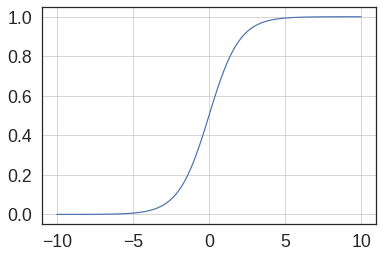

In [60]:
probabilities = sigmoid(z)
plt.plot(z, probabilities);
plt.grid();

In [61]:
### Logistic Regression

In [71]:
def eval_LR_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations + 1):
        
        
        z = np.dot(w, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        
        #y_pred = np.dot(w, X)
        #err = calc_mse(y, y_pred)
    
    
        w -= alpha * (1/n * np.dot((y_pred - y), X.T))
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w

In [63]:
w = eval_LR_model(X_st, y, iterations=1000, alpha=1e-2)

100 [ 0.25769171 -0.68297243  0.68841418  1.2405903 ] 0.5908596023453088
200 [ 0.14805533 -0.69317972  0.77965488  1.21287192] 0.5687278067099053
300 [ 0.06257746 -0.68605867  0.85181735  1.21283095] 0.5560473747533587
400 [-0.00887935 -0.68415387  0.90713736  1.22443854] 0.5476800278385013
500 [-0.0701621  -0.68661758  0.94984062  1.24404686] 0.541676599615156
600 [-0.1239972  -0.69202069  0.98318257  1.26924759] 0.5369841864977791
700 [-0.17239277 -0.69933957  1.00953865  1.29824779] 0.5330427663756572
800 [-0.21681092 -0.7078635   1.03062761  1.32973537] 0.5295551503580799
900 [-0.25830834 -0.71709934  1.04769231  1.36276535] 0.5263621224044183
1000 [-0.29764618 -0.72670545  1.061634    1.39666497] 0.5233765331724747


In [64]:
### Домашние задания

1. *Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - np.clip).  
2. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss был минимальным.
3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred_proba).
4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred).
5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.
6. Могла ли модель переобучиться? Почему?
7. *Создайте функции eval_LR_model_l1 и eval_LR_model_l2 с применением L1 и L2 регуляризации соответственно.

2. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [80]:
alpha_list = np.linspace(1e-8, 1e-1,  10)
for i in alpha_list:
  print(f"alfa={i}")
  eval_LR_model(X_st, y, iterations=2000, alpha=i)
  print()

alfa=1e-08
200 [ 0.49671337 -0.13826667  0.6476885   1.5230287 ] 1.220061879130942
400 [ 0.49671259 -0.13826903  0.64768846  1.52302755] 1.2200581116396614
600 [ 0.49671181 -0.1382714   0.64768842  1.5230264 ] 1.2200543441536351
800 [ 0.49671104 -0.13827376  0.64768838  1.52302524] 1.2200505766728649
1000 [ 0.49671026 -0.13827613  0.64768834  1.52302409] 1.2200468091973502
1200 [ 0.49670948 -0.1382785   0.64768831  1.52302294] 1.2200430417270893
1400 [ 0.4967087  -0.13828086  0.64768827  1.52302179] 1.220039274262087
1600 [ 0.49670792 -0.13828323  0.64768823  1.52302063] 1.220035506802339
1800 [ 0.49670714 -0.13828559  0.64768819  1.52301948] 1.2200317393478457
2000 [ 0.49670636 -0.13828796  0.64768815  1.52301833] 1.2200279718986065

alfa=0.01111112
200 [ 0.12754115 -0.69131206  0.79740873  1.21151591] 0.5653996856927244
400 [-0.03721473 -0.68479856  0.92749038  1.23231349] 0.5448018051778577
600 [-0.15678341 -0.69673401  1.00143872  1.28824327] 0.5342980941722031
800 [-0.25382864 -0.

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred_proba).

In [81]:
w = eval_LR_model(X_st, y, iterations=2000, alpha=i)

200 [-0.64245884 -0.81575707  1.11680356  1.72702881] 0.4995552177931558
400 [-1.25432451 -0.91736333  1.05455726  2.24457861] 0.4664467561141666
600 [-1.80755433 -0.96270374  0.90904148  2.64183838] 0.44201377632900957
800 [-2.31113497 -0.98420861  0.73842971  2.97447927] 0.42228858977623346
1000 [-2.77136565 -0.99588853  0.56641089  3.26813012] 0.4058781527072773
1200 [-3.193644   -1.00399774  0.40259598  3.53557456] 0.3920245709386051
1400 [-3.58276075 -1.01127932  0.2502806   3.78366682] 0.3802012406906377
1600 [-3.9429576  -1.01884757  0.10992481  4.01638187] 0.370008589285831
1800 [-4.27794785 -1.0270723  -0.01920407  4.23624356] 0.3611357882733707
2000 [-4.59094777 -1.0359998  -0.13825631  4.44501211] 0.3533392419345193


In [85]:
def calc_pred_proba(w, X):
  return sigmoid(w @ X)

In [89]:
y_pred_proba = calc_pred_proba(w, X_st)
y_pred_proba

array([0.25989757, 0.2490798 , 0.9081481 , 0.25445082, 0.74185696,
       0.47600875, 0.96815152, 0.1291874 , 0.26264914, 0.90202666])

4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются веса, которые уже посчитаны функцией eval_LR_model и X, на выходе - массив y_pred).

In [109]:
def calc_pred(y):
  return [1 if i>0.5 else 0 for i in y]  

In [110]:
y_pred = calc_pred(y_pred_proba)
y_pred

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]

5. Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.

In [111]:
def accuracy(y, y_pred):
  if len(y) != len(y_pred):
    raise Exception('Неверные данные')
  tr_an = 0
  for i in range(len(y)):
    if y[i] == y_pred[i]:
      tr_an += 1
  return tr_an/(len(y))
accuracy(y, y_pred)

0.9

In [112]:
def metr(y, y_pred, b):
  if len(y) != len(y_pred):
    raise Exception('Неверные данные')
  tp, fp, tn, fn = 0, 0 , 0 , 0
  for i in range(len(y)):
    if y[i] == y_pred[i] and y_pred[i] == 1:
      tp += 1
    elif y[i] != y_pred[i] and y_pred[i] == 1:
      fp += 1
    elif y[i] == y_pred[i] and y_pred[i] == 0:
      tn += 1
    elif y[i] != y_pred[i] and y_pred[i] == 0:
      fn += 1
    else:
      raise Exception('ошибка при составнении матрици')
  prec = tp/(tp+fp)
  rec = tp/(tp+fn)
  f = (1+b**2)* prec*rec/(b**2*prec+rec)
  print(f'Матрица ошибок: {[[tp, fp], [tn, fn]]}')
  print(f'Precision: {prec}')
  print(f'Recall: {rec}')
  print(f'F{b}: {f}')
  return [[tp, fp], [tn, fn]], prec, rec, f
a = metr(y, y_pred, 1)

Матрица ошибок: [[4, 0], [5, 1]]
Precision: 1.0
Recall: 0.8
F1: 0.888888888888889


6. Могла ли модель переобучиться? Почему?

In [ ]:
Модель не переобучена, так как в результатах отсутствуют ложные сробатывания модели.